# Trained model evaluation

## Setup

### Global imports

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import os
import json
import time

from tabulate import tabulate
from statistics import mean
from sklearn.metrics import ConfusionMatrixDisplay

### Variables

In [44]:
PREDICTIONS_DIR = os.path.join(os.getcwd(), '..', 'models', 'predictions')
EVALUATIONS_DIR = os.path.join(os.getcwd(), '..', 'models', 'evaluations')

### Helpers and utility

In [45]:
class MetricTracker:
    def __init__(self, model_name):
        self.model_name = model_name
        self.mIoU = tf.keras.metrics.OneHotMeanIoU(
            num_classes = 7,
            name = f'mIoU_{model_name}'
        )
        self.class_names = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
        self.IoU_scores = [tf.keras.metrics.OneHotIoU(
            num_classes = 7,
            name = f'IoU_{model_name}_{self.class_names[i]}',
            target_class_ids = [i]
        ) for i in range(7)]
        self.timings_ms = []
        self.confusion_matrices = []
        
    def update_state(self, mask, mask_pred, timing_ms):
        self.mIoU.update_state(mask, mask_pred)
        for metric in self.IoU_scores:
            metric.update_state(mask, mask_pred)
        self.timings_ms.append(timing_ms)
        mask_flat_indexed = tf.reshape(tf.argmax(mask, axis=-1), shape=-1)
        mask_pred_flat_indexed = tf.reshape(tf.argmax(mask_pred, axis=-1), shape=-1)
        self.confusion_matrices.append(tf.math.confusion_matrix(
            mask_flat_indexed,
            mask_pred_flat_indexed,
            num_classes=7 ))

    def calculate_final_confusion_matrix(self):
        cum_conf_matrix = tf.math.confusion_matrix([],[],num_classes=7)
        for m in self.confusion_matrices:
            cum_conf_matrix = tf.math.add(cum_conf_matrix, m)
        avg_conf_matrix = tf.math.divide(cum_conf_matrix, tf.constant(len(self.confusion_matrices))).numpy().astype('int16')
        return avg_conf_matrix

    def result(self):
        table = [['all (mIoU)', self.mIoU.result().numpy()]]
        for i,m in enumerate(self.IoU_scores):
            table.append([self.class_names[i], m.result().numpy()])

        avg_conf_matrix = self.calculate_final_confusion_matrix()

        print('Intersection over Union scores')
        print('-----')
        print(tabulate(table, headers=['class', 'score']))
        print('\n' * 2)
        print('Timing information')
        print('-----')
        print(f'average prediction duration: {mean(self.timings_ms):.1f}ms')
        print('\n' * 2)
        print('Confusion Matrix')
        print('-----')
        disp = ConfusionMatrixDisplay(confusion_matrix=avg_conf_matrix, display_labels=self.class_names)
        disp.plot(xticks_rotation='vertical')

    def result_to_json(self):
        result = {}
        result['mIoU'] = str(self.mIoU.result().numpy())
        result['IoU'] = {}
        result['avg_pred_ms'] = str(mean(self.timings_ms))
        for i,m in enumerate(self.IoU_scores):
            result['IoU'][self.class_names[i]] = str(m.result().numpy())

        file_path = os.path.join(EVALUATIONS_DIR, self.model_name, 'result.json')
        with open(file_path, 'w') as fp:
            json.dump(result, fp)

        avg_conf_matrix = self.calculate_final_confusion_matrix()
        np.save(os.path.join(EVALUATIONS_DIR, self.model_name, 'result_confusion_matrix'), avg_conf_matrix)

In [46]:
def index_to_rgb(indexed_image):
    palette = [
        [0, 255, 255],   # urban_land
        [255, 255, 0],   # agriculture_land
        [255, 0, 255],   # rangeland
        [0, 255, 0],     # forest_land
        [0, 0, 255],     # water
        [255, 255, 255], # barren_land
        [0, 0, 0]        # unknown
    ]

    # Convert indexed image to one-hot representation
    one_hot_map = tf.one_hot(tf.squeeze(indexed_image, axis=-1), depth=len(palette), dtype=tf.float32)

    # Use one-hot map and palette to reconstruct RGB image
    reconstructed_image = tf.reduce_sum(tf.expand_dims(one_hot_map, axis=-1) * tf.constant(palette, dtype=tf.float32), axis=-2)

    return tf.cast(reconstructed_image, dtype=tf.uint8)

In [47]:
def display(display_list, file_name):
    plt.figure(figsize=(5, 5))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    print(len(display_list))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        data = display_list[i][0]
        # if i > 0:
        #     data = index_to_rgb(data)
        plt.imshow(tf.keras.utils.array_to_img(data, data_format='channels_last'))
        plt.axis('off')
    plt.suptitle(file_name[0].numpy())
    plt.show()

## Processing

### Early convnet

In [6]:
from src.data.pipelines import convnet_pipeline
from src.models import early_convnet

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Pipeline

In [7]:
BATCH_SIZE_IMAGES = 1
BATCH_SIZE_PATCHES = 1
IMAGE_SIZE = 224
PATCH_SIZE = 40
PATCH_SIZE_ANNOTATION = 2
PATCH_STRIDE = 1
SLICE_TRAIN = ':1'
SLICE_VALID = ':1'
SLICE_TEST = '85%:'

In [8]:
input_pipeline = convnet_pipeline.ConvnetPipeline(
    SLICE_TRAIN,
    SLICE_VALID,
    SLICE_TEST,
    BATCH_SIZE_IMAGES,
    BATCH_SIZE_PATCHES,
    IMAGE_SIZE,
    PATCH_SIZE,
    PATCH_SIZE_ANNOTATION,
    PATCH_STRIDE
)

2024-02-24 15:50:09.854169: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


#### Model

In [9]:
model = early_convnet.EarlyConvnet()
model.build((None, PATCH_SIZE + 20, PATCH_SIZE + 20, 3))     # 20 is for mirror padding border

checkpoint_filepath = os.path.join(os.getcwd(),'..', 'models', 'ckpt', 'early_convnet')
latest = tf.train.latest_checkpoint(checkpoint_filepath)
model.load_weights(latest)

#### Metrics and evaluation

In [10]:
tracker_1 = MetricTracker('convnet')

Intersection over Union scores
-----
class                 score
----------------  ---------
all (mIoU)        0.180365
urban_land        0.287831
agriculture_land  0.289793
rangeland         0.0765544
forest_land       0.338456
water             0.109731
barren_land       0.160191
unknown           0



Timing information
-----
average prediction duration: 421.4ms



Confusion Matrix
-----


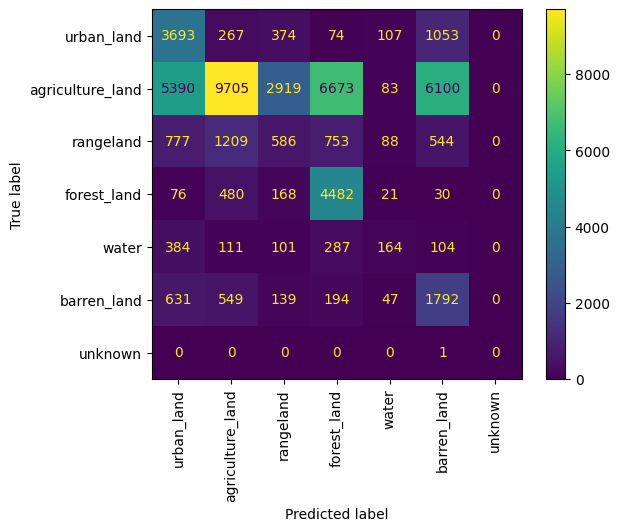

In [11]:
for patches, _, img, mask, file_name in input_pipeline.test:
    # Prediction with timer
    start = time.time_ns()
    pred = model.predict(patches, verbose=0)
    end = time.time_ns()
    duration_ms = (end - start) / 10e6
    mask_pred = tf.reshape(pred, shape=(1, 225, 225, 7))
    # "lose" the extra pixel: 225 => 224
    mask_pred = tf.image.crop_to_bounding_box(
            image=mask_pred,
            offset_height=0,
            offset_width=0,
            target_height=224,
            target_width=224
        )
    tracker_1.update_state(mask, mask_pred, duration_ms)
    # mask_indexed = tf.reshape(tf.argmax(input=mask, axis=3), shape=(1, 224, 224, 1))
    pred_indexed = tf.reshape(tf.argmax(input=mask_pred, axis=3), shape=(1, 224, 224, 1))
    # mask_rgb = index_to_rgb(mask_indexed)
    pred_rgb = index_to_rgb(pred_indexed)

    file_path = os.path.join(PREDICTIONS_DIR, tracker_1.model_name, tf.compat.as_str(file_name[0].numpy()))
    tf.keras.utils.save_img(file_path, pred_rgb[0], data_format='channels_last')
tracker_1.result_to_json()
tracker_1.result()

### FCN-8s

In [10]:
import src.data.pipelines.fcn_pipeline as fcn_pipeline
from src.models import fcn

#### Pipeline

In [11]:
SPLIT_TRAIN = ":1"
SPLIT_VALID = ":1"
SPLIT_TEST = "85%:"
BATCH_SIZE = 1
IMAGE_SIZE = 224

In [12]:
(_, _, test) = fcn_pipeline.getFCNPipeline(
        SPLIT_TRAIN,
        SPLIT_VALID,
        SPLIT_TEST,
        BATCH_SIZE,
        IMAGE_SIZE
    )

#### Model

In [13]:
model = fcn.get_fcn_8s()
weights_filepath = os.path.join(os.getcwd(),'..', 'models', 'ckpt', 'fcn-8s', '378_val_loss:_2.085226058959961.h5')
model.load_weights(weights_filepath)

#### Metrics and evaluation

In [16]:
tracker_2 = MetricTracker('fcn-8s')

Intersection over Union scores
-----
class                 score
----------------  ---------
all (mIoU)        0.427563
urban_land        0.577781
agriculture_land  0.788741
rangeland         0
forest_land       0.625396
water             0.516648
barren_land       0.408428
unknown           0.0759494



Timing information
-----
average prediction duration: 33.1ms



Confusion Matrix
-----


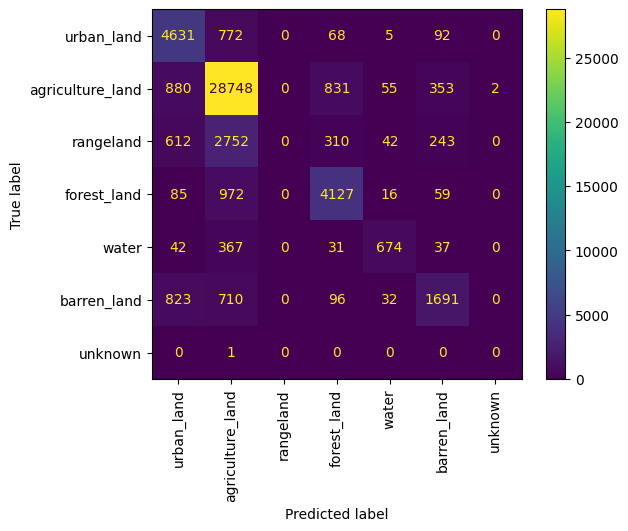

In [17]:
for img, mask, file_name in test:
    # Prediction with timer
    start = time.time_ns()
    pred = model.predict(img, verbose=0)
    end = time.time_ns()
    duration_ms = (end - start) / 10e6
    
    tracker_2.update_state(mask, pred, duration_ms)
    pred_indexed = tf.reshape(tf.argmax(input=pred, axis=3), shape=(1, 224, 224, 1))
    pred_rgb = index_to_rgb(pred_indexed)

    file_path = os.path.join(PREDICTIONS_DIR, tracker_2.model_name, tf.compat.as_str(file_name[0].numpy()))
    tf.keras.utils.save_img(file_path, pred_rgb[0], data_format='channels_last')
tracker_2.result_to_json()
tracker_2.result()

### U-Net

In [6]:
import src.data.pipelines.unet_pipeline as unet_pipeline
from src.models import unet

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Pipeline

In [7]:
SPLIT_TRAIN = ":1"
SPLIT_VALID = ":1"
SPLIT_TEST = "85%:"
BATCH_SIZE = 1
IMAGE_SIZE = 228    # value model-compatible value to 224
BORDER = 92

In [8]:
(_, _, test) = unet_pipeline.getUNetPipeline(
        SPLIT_TRAIN,
        SPLIT_VALID,
        SPLIT_TEST,
        BATCH_SIZE,
        IMAGE_SIZE,
        BORDER
    )

2024-02-23 20:51:09.943932: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


#### Model

In [9]:
size = IMAGE_SIZE + BORDER * 2
model = unet.get_UNet(input_shape=(size, size, 3))
checkpoint_filepath = os.path.join(os.getcwd(),'..', 'models', 'ckpt', 'unet')
latest = tf.train.latest_checkpoint(checkpoint_filepath)
model.load_weights(latest)

#### Metrics and evaluation

In [12]:
tracker_3 = MetricTracker('unet')

Intersection over Union scores
-----
class                 score
----------------  ---------
all (mIoU)        0.358236
urban_land        0.590699
agriculture_land  0.738858
rangeland         0.0116241
forest_land       0.469289
water             0.374335
barren_land       0.322849
unknown           0



Timing information
-----
average prediction duration: 103.8ms



Confusion Matrix
-----


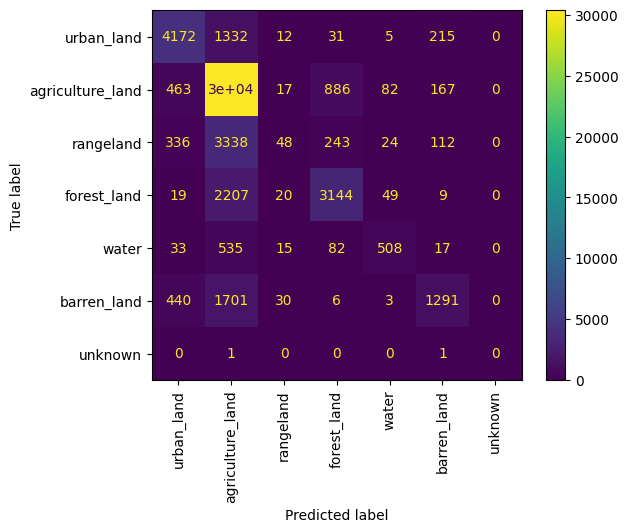

In [13]:
for img, mask, file_name in test:
    # Prediction with timer
    start = time.time_ns()
    pred = model.predict(img, verbose=0)
    end = time.time_ns()
    duration_ms = (end - start) / 10e6
    
    tracker_3.update_state(mask, pred, duration_ms)
    pred_indexed = tf.reshape(tf.argmax(input=pred, axis=3), shape=(1, 228, 228, 1))
    pred_rgb = index_to_rgb(pred_indexed)
    pred_rgb = tf.image.resize(pred_rgb, (224, 224), method='nearest')

    file_path = os.path.join(PREDICTIONS_DIR, tracker_3.model_name, tf.compat.as_str(file_name[0].numpy()))
    tf.keras.utils.save_img(file_path, pred_rgb[0], data_format='channels_last')
tracker_3.result_to_json()
tracker_3.result()

## Baseline

Static guess of majority class (agriculture land)

In [62]:
import src.data.pipelines.fcn_pipeline as fcn_pipeline

In [63]:
SPLIT_TRAIN = ":1"
SPLIT_VALID = ":1"
SPLIT_TEST = "85%:"
BATCH_SIZE = 1
IMAGE_SIZE = 224

In [64]:
(_, _, test) = fcn_pipeline.getFCNPipeline(
        SPLIT_TRAIN,
        SPLIT_VALID,
        SPLIT_TEST,
        BATCH_SIZE,
        IMAGE_SIZE
    )

In [69]:
predictions = np.ndarray(shape=(224, 224))
predictions.fill(1)

pred_indexed = tf.reshape(tf.constant(predictions, dtype=tf.int32), shape=(1, 224, 224))
pred_one_hot = tf.one_hot(indices=pred_indexed, depth=7, axis=-1)

#### Metrics and evaluation

In [74]:
tracker_4 = MetricTracker('baseline_static')

Intersection over Union scores
-----
class                 score
----------------  ---------
all (mIoU)        0.0878965
urban_land        0
agriculture_land  0.615276
rangeland         0
forest_land       0
water             0
barren_land       0
unknown           0



Timing information
-----
average prediction duration: 0.0ms



Confusion Matrix
-----


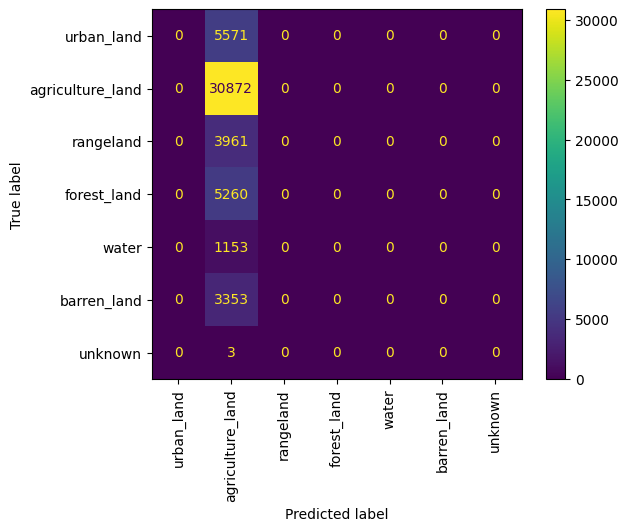

In [75]:
for img, mask, file_name in test:
    duration_ms = 0 # Static prediction requires no time
    
    tracker_4.update_state(mask, pred_one_hot, duration_ms)
    # pred_indexed = tf.reshape(tf.argmax(input=pred, axis=3), shape=(1, 228, 228, 1))
    # pred_rgb = index_to_rgb(pred_indexed)
    # pred_rgb = tf.image.resize(pred_rgb, (224, 224), method='nearest')

    # file_path = os.path.join(PREDICTIONS_DIR, tracker_4.model_name, tf.compat.as_str(file_name[0].numpy()))
    # tf.keras.utils.save_img(file_path, pred_rgb[0], data_format='channels_last')
tracker_4.result_to_json()
tracker_4.result()

## Comparison